In [1]:
import numpy as np
import pandas as pd
import vectorbt as vbt
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas_ta as ta
import yfinance as yf 
import warnings
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

### Load Data

In [2]:
# BTC Full
btc = pd.read_csv('2022.2.9BTCUSDT-H1-NoSession.csv')
btc.Date = btc.Date.astype(str)+' '+ btc.Time
btc.Date = pd.to_datetime(btc.Date)
btc.drop(columns= ['Time'], inplace = True)
btc = btc.set_index('Date')

In [3]:
# EURUSD Full
df = pd.read_csv('2022.2.9EURUSD-H4-NoSession.csv')
df.Date = df.Date.astype(str)+' '+ df.Time
df.Date = pd.to_datetime(df.Date)
df.drop(columns= ['Time'], inplace = True)
df = df.set_index('Date')

##### Trend, Non-Trend Data

In [4]:
dftr1 = pd.read_csv('TRE_EURUSD_2011_2015.csv', index_col = 'Date')
dftr2 = pd.read_csv('TRE_EURUSD_2017_2018.csv', index_col = 'Date')
# ------------------------------------------------------------------
dfsw1 = pd.read_csv('SW_EURUSD_2015_2017_4H.csv', index_col = 'Date')
dfsw2 = pd.read_csv('SW_EURUSD_2010_2014_4H.csv', index_col = 'Date')

### Util Function

In [5]:
#initial
def set_up_df(df:pd.DataFrame , index):  
    df1    =   pd.DataFrame(columns=index)
    df1['date']  =    df.index 
    df1.date = pd.to_datetime(df1.date,format='%Y-%m-%d')
    df1 = df1.set_index('date')
    return df1

#for calculate duration
def convert_to_hours(delta):
    total_seconds = delta.total_seconds()
    hours = str(int(total_seconds // 3600))
    return hours

#Performance Matric
def cal_consecutive(df:pd.DataFrame):
    df['win']= np.sign(df) # assign sign on log
    blocks = df['win'].ne(df['win'].shift()).cumsum() 
    df['consecutive_WL'] = df['win'].groupby(blocks).cumsum()
    return df['consecutive_WL'] 

def Cal_portstat(port):
    port_return = port.total_return().to_frame()
    port_return['MaxDD'] = port.max_drawdown()
    port_return['NumTrade'] = port.trades.count()
    port_return['WinRate'] = port.trades.win_rate()
    port_return['AvgWinningTrade'] = port.trades.winning.returns.mean()
    port_return['AvgLosingTrade'] = port.trades.losing.returns.mean()
    port_return['SharpRatio'] = port.returns_acc.sharpe_ratio()
    return port_return

def Cal_pip(df):
    pip = []
    pipp = df['Avg Exit Price'] - df['Avg Entry Price']
    for i in portfinal['Direction']:
        if i == 'Long':
            pip.append(1)
        else :
            pip.append(-1)    
    return (pip * pipp) 

def Cal_mae_mfe(data,port):
    MAE = []
    MFE = []
    for i,j,y,k in zip(port['Entry Timestamp'], port['Exit Timestamp'], port['Avg Entry Price'], port['Direction']):
        if k == 'Long':
            MFE.append((data.loc[i:j]['High'].max() - y)/y)
            MAE.append((y - df.loc[i:j]['Low'].min())/y)
        else :
            MAE.append((data.loc[i:j]['High'].max() - y)/y)
            MFE.append((y - df.loc[i:j]['Low'].min())/y)
    return MAE, MFE  

def Calkelly(port):
    init_cash = 10000
    W = port.stats()[15]/100
    A = abs(port.stats()[19])
    B = port.stats()[18]
    Percent_kelly = (W/A) - ((1-W)/B)
    riskpertrade = Percent_kelly * init_cash
    print(f'Percent_kelly = {Percent_kelly}')


### Define Strategy Function

In [6]:
help(df.ta.vidya)

Help on method vidya in module pandas_ta.core:

vidya(length=None, offset=None, **kwargs) method of pandas_ta.core.AnalysisIndicators instance



In [7]:
def strategy(df, length1= 15, length2 = 34):
    df['vid1'] = df.ta.vidya(length1)
    df['vid2'] = df.ta.vidya(length2)
    df['macd'] = df.ta.macd(12,26)['MACDh_12_26_9']
    

    l1 = (df['vid1'] > df['vid2']) & (df['vid1'].shift(1) < df['vid2'])
    l2 = df['macd'] > 0
    df['long_signal'] = l1 & l2

    s1 = (df['vid1'] < df['vid2']) & (df['vid1'].shift(1) > df['vid2'])
    s2 = df['macd'] < 0
    df['short_signal'] = s1 & s2

    df['long_exit'] = s1
    df['short_exit'] = l1

    return df

------------------------------------------------------------------

### Backtest Strategy

#### Default Strategy

In [8]:
def run_strategy(df, timeframe = '1h', cash = 10000):
    df = strategy(df)
    port = vbt.Portfolio.from_signals(df.Close,
                                    entries = df['long_signal'],
                                    exits = df['long_exit'],
                                    short_entries = df['short_signal'],
                                    short_exits = df['short_exit'],
                                    freq = timeframe,
                                    init_cash = cash,
                                    fees = 0.00,
                                    slippage = 0.00)
    return port

In [9]:
run_strategy(df).stats()

Start                                2003-05-05 00:00:00
End                                  2022-02-07 20:00:00
Period                                1262 days 00:00:00
Start Value                                      10000.0
End Value                                   12139.249766
Total Return [%]                               21.392498
Benchmark Return [%]                            2.004244
Max Gross Exposure [%]                             100.0
Total Fees Paid                                      0.0
Max Drawdown [%]                               31.424822
Max Drawdown Duration                  463 days 11:00:00
Total Trades                                         206
Total Closed Trades                                  205
Total Open Trades                                      1
Open Trade PnL                                -22.599949
Win Rate [%]                                   28.780488
Best Trade [%]                                 19.864046
Worst Trade [%]                

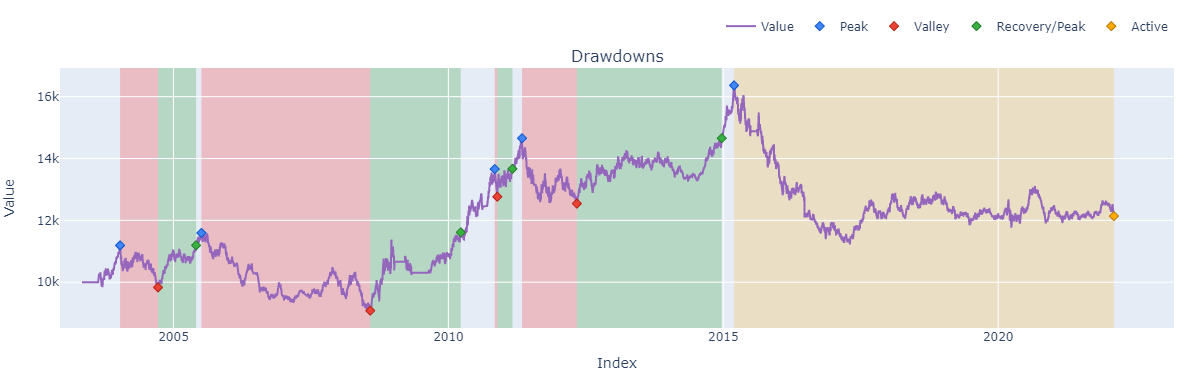

In [10]:
run_strategy(df).plot(subplots=['drawdowns']).show() # Equity Curve

----------------------------------------

### Add Stop Loss

In [ ]:
def run_strategy_sl(df, timeframe = '1h', cash = 10000, multiply = 1):
    df = strategy(df)
    df['vol'] = df.ta.stdev().ewm(alpha=0.96).mean()
    df['sl_stop'] = (df['vol'] * multiply) / df.Close
    
    port = vbt.Portfolio.from_signals(df.Close,
                                    entries = df['long_signal'],
                                    exits = df['long_exit'] ,
                                    short_entries = df['short_signal'],
                                    short_exits = df['short_exit'],
                                    freq = timeframe,
                                    init_cash = cash,
                                    fees = 0.00, sl_stop = df['sl_stop'],
                                    slippage = 0.00)
    return port

# Optimise Vol Multiply
portstats = []
start, end, step = (0.1, 4, 0.1)
array = np.arange(start,end,step)
for i in array:
    port = run_strategy_sl(df, multiply = i)
    portstats.append(port.stats())
pd.DataFrame(portstats).sort_values('Sharpe Ratio',ascending=False).head(5)     # Sort for best param

#### Strategy with Volatility SL

In [ ]:
def run_strategy_sl(df, timeframe = '1h', cash = 10000, multiply = 1):
    df = strategy(df)
    df['vol'] = df.ta.stdev().ewm(alpha=0.96).mean()
    df['sl_stop'] = (df['vol'] * multiply) / df.Close
    
    port = vbt.Portfolio.from_signals(df.Close,
                                    entries = df['long_signal'],
                                    exits = df['long_exit'] ,
                                    short_entries = df['short_signal'],
                                    short_exits = df['short_exit'],
                                    freq = timeframe,
                                    init_cash = cash,
                                    fees = 0.00, sl_stop = df['sl_stop'],
                                    slippage = 0.00)
    return port

# Optimise Vol Multiply
portstats = []
start, end, step = (0.1, 4, 0.1)
array = np.arange(start,end,step)
for i in array:
    port = run_strategy_sl(df, multiply = i)
    portstats.append(port.stats())
pd.DataFrame(portstats).sort_values('Sharpe Ratio',ascending=False).head(5)     # Sort for best param

In [ ]:
run_strategy_sl(df, multiply = 1.7).stats()

In [ ]:
run_strategy_sl(df, multiply = 1.7).plot(subplots=['drawdowns']).show() # Equity Curve

--------------------------------------------------

#### Strategy with Volatility SL (Fix Risk per trade)

In [ ]:
#if reach stoploss price it will loss 1% of cash 
def run_strategy_sl_fixRPT(df, timeframe = '1h', cash = 10000, multiply = 1.7, riskpertrade = 0.01):
    df = strategy(df)
    df['vol'] = df.ta.stdev().ewm(alpha=0.96).mean()
    df['sl_stop'] = (df['vol'] * multiply) / df.Close
    df['size'] = ((riskpertrade * cash)/df['sl_stop'])/ df.Close
    port = vbt.Portfolio.from_signals(df.Close,
                                    entries = df['long_signal'],
                                    exits = df['long_exit'] ,
                                    short_entries = df['short_signal'],
                                    short_exits = df['short_exit'],
                                    freq = timeframe,
                                    init_cash = cash, size = df['size'],
                                    fees = 0.00, sl_stop = df['sl_stop'],
                                    slippage = 0.00)
    return port

In [ ]:
run_strategy_sl_fixRPT(df).stats()

#### Trend Data 1

In [ ]:
run_strategy_sl_fixRPT(df).plot(subplots=['drawdowns']).show() # Equity Curve

In [ ]:
dftr1 = strategy(dftr1)
fig = dftr1.Close.vbt.plot(trace_kwargs=dict(name='Close'))
run_strategy_sl_fixRPT(dftr1).positions.plot(close_trace_kwargs=dict(visible=False), fig=fig)
fig.show()
run_strategy_sl_fixRPT(dftr1).plot(subplots=['drawdowns']).show()
(np.log(dftr1.Close/dftr1.Close.shift(1)).rolling(200).std()*252**.5).ewm(alpha=0.96).mean().vbt.plot().show() # Volatility

####  Trend Data 2

### Strategy test with Trend Period

In [ ]:
dftr2 = strategy(dftr2)
fig = dftr2.Close.vbt.plot(trace_kwargs=dict(name='Close'))
run_strategy_sl_fixRPT(dftr2).positions.plot(close_trace_kwargs=dict(visible=False), fig=fig)
fig.show()
run_strategy_sl_fixRPT(dftr2).plot(subplots=['drawdowns']).show()
(np.log(dftr2.Close/dftr2.Close.shift(1)).rolling(200).std()*252**.5).ewm(alpha=0.96).mean().vbt.plot().show() # Volatility

### Strategy test with non-Trend Period

####  Non-Trend Data 1

In [ ]:
dfsw1 = strategy(dfsw1)
fig = dfsw1.Close.vbt.plot(trace_kwargs=dict(name='Close'))
run_strategy_sl_fixRPT(dfsw1).positions.plot(close_trace_kwargs=dict(visible=False), fig=fig)
fig.show()
run_strategy_sl_fixRPT(dfsw1).plot(subplots=['drawdowns']).show()
(np.log(dfsw1.Close/dfsw1.Close.shift(1)).rolling(200).std()*252**.5).ewm(alpha=0.96).mean().vbt.plot().show() # Volatility

####  Non-Trend Data 2

In [ ]:
dfsw2 = strategy(dfsw2)
fig = dfsw2.Close.vbt.plot(trace_kwargs=dict(name='Close'))
run_strategy_sl_fixRPT(dfsw2).positions.plot(close_trace_kwargs=dict(visible=False), fig=fig)
fig.show()
run_strategy_sl_fixRPT(dfsw2).plot(subplots=['drawdowns']).show()
(np.log(dfsw2.Close/dfsw2.Close.shift(1)).rolling(200).std()*252**.5).ewm(alpha=0.96).mean().vbt.plot().show() # Volatility

### Final

In [ ]:

df = strategy(df)
#add to Empty Dataframe
LongEntries = df.long_signal
LongExit = df.long_exit      
ShortEntries = df.short_signal
ShortExit = df.short_exit

df['vol'] = df.ta.stdev().ewm(alpha=0.96).mean()
df['sl_stop'] = (df['vol'] * 1.7) / df.Close
df['size'] = ((0.01 * 10000)/df['sl_stop'])/ df.Close
port = vbt.Portfolio.from_signals(df.Close,
                            entries = df['long_signal'],
                            exits = df['long_exit'] ,
                            short_entries = df['short_signal'],
                            short_exits = df['short_exit'],
                            freq = '1h',
                            init_cash = 10000, size = df['size'],
                            fees = 0.00, sl_stop = df['sl_stop'],
                            slippage = 0.00)
port.stats()

In [ ]:
port.plot(subplots=['drawdowns']).show() # Equity Curve

In [ ]:
portfinal = port.trades.records_readable
portfinal['PnL_pip'] = Cal_pip(portfinal)

In [ ]:
print(f"Consecutive loss = {np.abs(cal_consecutive(portfinal['PnL']).min())}")
print(f"Consecutive win = {np.abs(cal_consecutive(portfinal['PnL']).max())}")

In [ ]:
Holding_period = (portfinal['Exit Timestamp'] - portfinal['Entry Timestamp']).apply(convert_to_hours).astype('int')
Holding_period.describe()

In [ ]:
def hurst_exponent(df, max_lag=20):
    lags = range(2, max_lag)
    tau = [np.std(np.subtract(df.values[lag:], df.values[:-lag]),dtype=np.float64) for lag in lags]
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [ ]:

for lag in [20, 100, 300, 500, 1000]:
    hurst_exp = get_hurst_exponent(df["Close"].values, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

### Research

In [ ]:
portfinal = port.trades.records_readable
tradingdata = df.reset_index()
tradingdata = tradingdata[['Date', 'Open', 'High', 'Low', 'Close']]

In [ ]:
tradingdata['_normPrice'] = (tradingdata.Close-tradingdata.Low)/(tradingdata.High-tradingdata.Low)
tradingdata['_avgreturn5'] = ta.sma(tradingdata.Close.pct_change(),5)
tradingdata['_avgreturn10'] = ta.sma(tradingdata.Close.pct_change(),10)
tradingdata['_avgreturn30'] = ta.sma(tradingdata.Close.pct_change(),30)
tradingdata['_avgreturn60'] = ta.sma(tradingdata.Close.pct_change(),60)
tradingdata['_rsi5'] = ta.rsi(tradingdata['Close'],5)
tradingdata['_rsi7'] = ta.rsi(tradingdata['Close'],7)
tradingdata['_rsi14'] = ta.rsi(tradingdata['Close'],14)
tradingdata['_rsi30'] = ta.rsi(tradingdata['Close'],30)
tradingdata['_rsi60'] = ta.rsi(tradingdata['Close'],60)
tradingdata['_slope3'] = tradingdata.ta.slope(3)
tradingdata['_slope5'] = tradingdata.ta.slope(5)
tradingdata['_slope10'] = tradingdata.ta.slope(10)
tradingdata['_slope20'] = tradingdata.ta.slope(20)
tradingdata['_macd12_26'] = tradingdata.ta.macd(12,26)['MACDh_12_26_9']
tradingdata['_macd10_30'] = tradingdata.ta.macd(10,30)['MACDh_10_30_9']
tradingdata['_macd5_10'] = tradingdata.ta.macd(5,10)['MACDh_5_10_9']
tradingdata['_macd2_10'] = tradingdata.ta.macd(2,10)['MACDh_2_10_9']
tradingdata['_macd12_26_change'] = tradingdata.ta.macd(12,26)['MACDh_12_26_9'].pct_change()
tradingdata['_macd10_30_change'] = tradingdata.ta.macd(10,30)['MACDh_10_30_9'].pct_change()
tradingdata['_macd5_10_change'] = tradingdata.ta.macd(5,10)['MACDh_5_10_9'].pct_change()
tradingdata['_macd2_10_change'] = tradingdata.ta.macd(2,10)['MACDh_2_10_9'].pct_change()
tradingdata['_avgema2_price'] = tradingdata.ta.ema(2)/tradingdata.Close
tradingdata['_avgema10_price'] = tradingdata.ta.ema(10)/tradingdata.Close
tradingdata['_avgema20_price'] = tradingdata.ta.ema(20)/tradingdata.Close
tradingdata['_avgema50_price'] = tradingdata.ta.ema(50)/tradingdata.Close
tradingdata['BBwid'] = tradingdata.ta.bbands()['BBU_5_2.0'] - tradingdata.ta.bbands()['BBL_5_2.0']
tradingdata['_adx'] = ta.adx(tradingdata['High'],tradingdata['Low'],tradingdata['Close']).iloc[:,:1]
tradingdata['_stochK'] = ta.stoch(tradingdata['High'], tradingdata['Low'], tradingdata['Close']).iloc[:,:1]
tradingdata['_natr'] = ta.natr(tradingdata['High'], tradingdata['Low'], tradingdata['Close'])
tradingdata['_stdev'] = ta.stdev(tradingdata['Close'])
tradingdata['_truerange'] =  ta.true_range(tradingdata['High'], tradingdata['Low'], tradingdata['Close'])
tradingdata['_stdev'] = ta.stdev(tradingdata['Close'])

In [ ]:
full_position_data = tradingdata.merge(portfinal, left_on = 'Date', right_on = 'Entry Timestamp')
full_position_data.dropna(inplace = True)

##### only long position

In [ ]:
full_position_data = full_position_data[full_position_data['Direction'] == 'Long']

In [ ]:
# class count
full_position_data['target'] = np.where(full_position_data['Return'] > 0, 1, 0)
class_count_0, class_count_1 = full_position_data['target'].value_counts()

class_0 = full_position_data[full_position_data['target'] == 0]
class_1 = full_position_data[full_position_data['target'] == 1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

In [ ]:
class_1_sample = class_1.sample(384)
class_0_sample = class_0.sample(384)
mldata = pd.concat([class_1_sample, class_0_sample], axis=0)
mldata['target'].value_counts()

In [ ]:
cols = ['_normPrice', '_avgreturn5',
       '_avgreturn10', '_avgreturn30', '_avgreturn60', '_rsi5', '_rsi7',
       '_rsi14', '_rsi30', '_rsi60', '_slope3', '_slope5', '_slope10',
       '_slope20', '_macd12_26', '_macd10_30', '_macd5_10', '_macd2_10',
       '_macd12_26_change', '_macd10_30_change', '_macd5_10_change',
       '_macd2_10_change', '_avgema2_price', '_avgema10_price',
       '_avgema20_price', '_avgema50_price', 'BBwid', '_adx', '_stochK',
       '_natr', '_stdev', '_truerange']
X = mldata[cols]
y = mldata['target']

In [ ]:
plt.figure(figsize=(10, 6))
sns.swarmplot(data = mldata, x = 'target', y='_macd2_10_change')

In [ ]:
import pingouin as pg
for i in cols:
    a = mldata[mldata.target ==1][i].reset_index(drop=True)
    b = mldata[mldata.target ==0][i].reset_index(drop=True)
    print(i)
    print(pg.ttest(a, b).iloc[:,:7])